### Individual solution with the plots

In [1]:
using PyCall
using Distributions
using Statistics

using Distances
using Random , Formatting
using AstroLib

push!(LOAD_PATH,"/home/stephane/Science/GAIA/master/src")
using GaiaClustering

import PyPlot

@pyimport astroquery.vizier as vizier
@pyimport astropy.units as u
@pyimport astropy.coordinates as coord


## directory
rootdir = "/home/stephane/Science/GAIA"
wdir    = "$rootdir/products"
plotdir = "$rootdir/products/test"

cd(wdir)

mutable struct twomass
    J::Array{Float64}
    Jerr::Array{Float64}
    H::Array{Float64}
    Herr::Array{Float64}
    K::Array{Float64}
    Kerr::Array{Float64}
end

In [2]:
function getdata(filevot)
    voname = filevot

    data       = read_votable(voname)
    df         = filter_data(data)
    dfcart     = add_cartesian(df)
    blck       = [[1,2,3],[4,5], [6,7,8]]
    wghtblck   = [4.0,5.0,1.0]
    wghtblck   = [3.03, 9.05, 1.83]
    norm       = "identity"

    dfcartnorm , scale8 = normalization_PerBlock(dfcart, blck, wghtblck , norm, false) 
    return(df, dfcart , dfcartnorm)
end

getdata (generic function with 1 method)

In [3]:
## Get the 2Mass Magnitudes

function get_2MASS(indx, df::GaiaClustering.Df)
    s = length(indx)
    tm = twomass(zeros(s),zeros(s),zeros(s),zeros(s),zeros(s),zeros(s)) 
    
    for i in 1:s
        c = coord.SkyCoord(ra= df.raw[1,indx[i]], dec=df.raw[2,indx[i]]  , unit=(u.deg, u.deg), frame="icrs")
        res = vizier.Vizier[:query_region](c , width="5s",catalog="II/246")
        if length(res) > 0
            tm.J[i]    = res[1][1][4][1]
            tm.Jerr[i] = res[1][1][5][1]
            tm.H[i]    = res[1][1][6][1]
            tm.Herr[i] = res[1][1][7][1]
            tm.K[i]    = res[1][1][8][1]
            tm.Kerr[i] = res[1][1][9][1]            
        end
    end
    return(tm)
end
    

get_2MASS (generic function with 1 method)

In [4]:
## label from the dbscan labels with maximum stars
function _find_cluster_label(labels)
    let
    i = 1 ; nmax = 0 ; ilabel = 1
        for ilab in labels
            nlab = length(ilab)
            if nlab > nmax
                ilabel = i
                nmax= nlab
            end
            i += 1
        end
    return(ilabel, nmax)
    end
end


function _plot_cluster(plotdir, voname, indx, sc::GaiaClustering.SCproperties, tm::twomass , df::GaiaClustering.Df, showplot = true , cmap = "gist_stern")

    PyPlot.plt[:figure](figsize=(12.0,12.0))

    PyPlot.plt[:subplot](3, 3, 1 , xlim = [-20,20] , ylim = [-20,20])
    xx = df.data[2,indx]
    yy = df.data[3,indx]
    ## A circle of radius std(z)
    # xc = mean(df.data[2,indx]) ; yc = mean(df.data[3,indx])
    # circle1 = PyPlot.plt[:Circle](0.,0.,1.)
    PyPlot.plt[:scatter](xx, yy , s = 1.0 )
    PyPlot.plt[:xlabel]("Y (pc)")
    PyPlot.plt[:ylabel]("Z (pc)")
    PyPlot.plt[:grid](true)
    
    PyPlot.plt[:subplot](3, 3, 2 , ylim = [-20,20])
    xx = df.data[1,indx]
    yy = df.data[3,indx]
    PyPlot.plt[:scatter](xx, yy , s = 1.0 )
    PyPlot.plt[:xlabel]("X (pc)")
    PyPlot.plt[:ylabel]("Z (pc)")
    PyPlot.plt[:grid](true)
    
    PyPlot.plt[:subplot](3, 3, 3 , xlim = [-20,20])
    xx = df.data[2,indx]
    yy = df.data[1,indx]
    PyPlot.plt[:scatter](xx, yy , s = 1.0 )
    PyPlot.plt[:xlabel]("Y (pc)")
    PyPlot.plt[:ylabel]("X (pc)")
    PyPlot.plt[:grid](true)
    
    PyPlot.plt[:subplot](3, 3, 4 )
    xx = df.data[1,indx]
    yy = df.raw[11,indx]
    PyPlot.plt[:scatter](xx, yy , s = 1.0 )
    PyPlot.plt[:xlabel]("X(pc)")
    PyPlot.plt[:ylabel]("Vrad (km/s)")
    PyPlot.plt[:grid](true)    
        
    PyPlot.plt[:subplot](3, 3, 5)
    PyPlot.plt[:axis]("off")
    ## text to display
    text =[]
    v = sc.nstars ; txt = "N stars   : $v" ; push!(text,txt)
    v = fmt("3.1f",sc.distance) ; txt = "Distance  : $v (pc)" ; push!(text,txt)
    v = fmt("3.3f",sc.l) ; txt = "l         : $v (degree)" ; push!(text,txt)
    v = fmt("3.3f",sc.b) ; txt = "b         : $v (degree)" ; push!(text,txt)
    v = fmt("3.2f", sc.vra) ; txt = "VRA       : $v (km/s)" ; push!(text,txt)
    v = fmt("3.2f",sc.vdec) ; txt = "VDec      : $v (km/s)"; push!(text,txt)
    v = fmt("3.2f",sc.vrad) ; txt = "Vradial   : $v (km/s)"; push!(text,txt)    
    v = fmt("3.2f",sc.xdisp) ; txt = "X disp.   : $v (pc)" ; push!(text,txt)
    v = fmt("3.2f",sc.ydisp) ; txt = "Y disp.   : $v (pc)" ; push!(text,txt)
    v = fmt("3.2f",sc.zdisp) ; txt = "Z disp.   : $v (pc)" ; push!(text,txt)
    v = fmt("3.2f",sc.vradisp) ; txt = "VRA disp. : $v (km/s)" ; push!(text,txt)
    v = fmt("3.2f",sc.vdecdisp) ; txt = "VDec disp.: $v (km/s)" ; push!(text,txt)
    v = fmt("3.2f",sc.vraddisp) ; txt = "Vradial disp.: $v (km/s)" ; push!(text,txt)
    show_text(-0.01,0.0, text , 1.0)
    
    PyPlot.plt[:subplot](3, 3, 7 )
    PyPlot.plt[:axis]("on")    
    xx = df.data[7,indx]
    yy = -df.data[6,indx]
    PyPlot.plt[:scatter](xx, yy , s = 1.0 )
    PyPlot.plt[:xlabel]("G-Rp")
    PyPlot.plt[:ylabel]("G")
    PyPlot.plt[:grid](true)
    
    PyPlot.plt[:subplot](3, 3, 8 )
    xx = df.data[4,indx]
    yy = df.data[5,indx]
    PyPlot.plt[:scatter](xx, yy , s = 1.0 )
    PyPlot.plt[:xlabel]("Vra (km/s)")
    PyPlot.plt[:ylabel]("Vdec (km/s)")
    PyPlot.plt[:grid](true)
    
    PyPlot.plt[:subplot](3, 3, 9 , ylim =[-17,-6.])
    yy = -tm.J[:]
    xx = tm.J[:] .- tm.K[:]
    PyPlot.plt[:scatter](xx, yy , s = 1.0 )
    PyPlot.plt[:ylabel]("J")
    PyPlot.plt[:xlabel]("J-K")
    PyPlot.plt[:grid](true)
    
    
    figname = plotdir*"/"*voname*"-cluster.png"
    PyPlot.plt[:savefig](figname)
    if showplot PyPlot.plt[:show]() end
end

_plot_cluster (generic function with 3 methods)

## Main ...
## Votable test.vot read
## Filtering done ...
## Stars selected: 4461
## Cartesian transformation done ...
## Normalization identity done...
### [1pc,1pc,1pc,1km/s,1km/s,1mag,1mag,1mag] equivalent to [0.21351, 0.21351, 0.21351, 0.637712, 0.637712, 0.128952, 0.128952, 0.128952]
##
ϵ : 1.85
## dbscan..
## Search for 2MASS counterparts...
## done.
### 1 clusters found.
### Label solution: 1
### N stars: 795
GaiaClustering.SCproperties(795, 390.2268355314944, 83.82907067048959, -5.622117528556223, 209.2361604840893, -19.479039936032837, 2.568233604525119, 1.4304496226983552, -0.11177321327142722, 2.6498644292207874, -0.19472569255904593, 24.22065501629343, 18.019598702322707, 3.574455482983061, 2.202963908423934, 1.1957055792195002, 2.2572623140714794, 9.896304765627747)
 

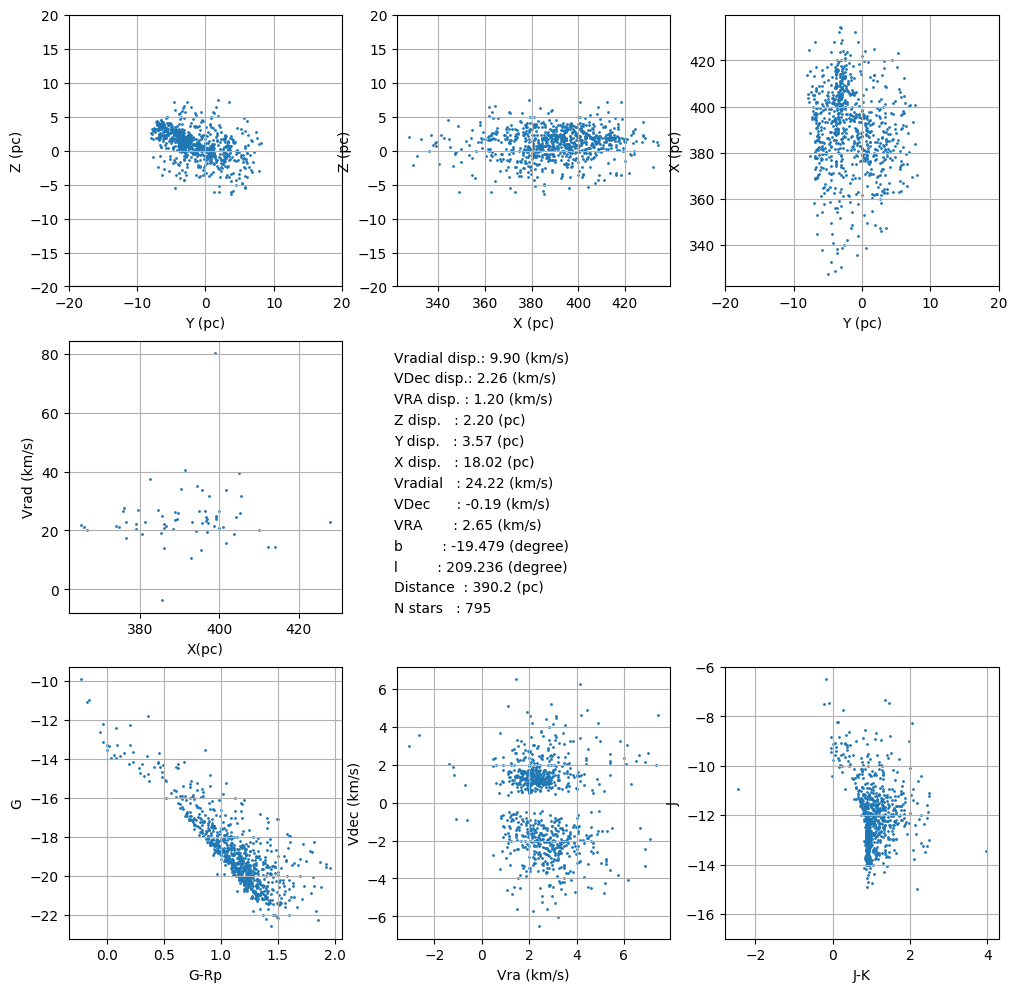


## Galactic velocity:
U: 19.91
V: -12.72
W: -5.94


In [5]:
macro main(votname)
    Random.seed!(1237)
    println("## Main ...")
    
    ## Get the cluster data..
    df ,  dfcart, dfnorm = getdata(votname)
    
    eps = 1.85
    min_nei = 9
    min_cl = 16
    println("ϵ : $eps")

    println("## dbscan..")
    labels = clusters(dfnorm.data , eps , 20, min_nei, min_cl)
    labelmax , nmax = find_cluster_label(labels)
    println("## Search for 2MASS counterparts...")
    tmass = get_2MASS(labels[labelmax] , df)
    println("## done.")
    
    println("### $(length(labels)) clusters found.")
    println("### Label solution: $labelmax")
    println("### N stars: $nmax")
    sc = get_properties_SC(labels[labelmax] , df, dfcart)
    println(sc)
    
    _plot_cluster(plotdir, votname, labels[labelmax], sc , tmass,  dfcart )
    
    ## SC kinematics
    println(" ")
    #println(sc.pmra)
    #println(sc.pmdec)
    #println(sc.parallax)
    println("## Galactic velocity:")
    u,v,w = gal_uvw(sc.ra, sc.dec, sc.pmra, sc.pmdec, sc.vrad , sc.parallax)
    s1= fmt("3.2f",u) ; println("U: $s1")
    s2= fmt("3.2f",v) ; println("V: $s2")
    s3= fmt("3.2f",w) ; println("W: $s3")
end

@main("test.vot")